<a href="https://www.kaggle.com/code/salma9201/image-captioning?scriptVersionId=215200504" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

In [2]:
import numpy as np
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate,Add
from tensorflow.keras.models import Model
import tensorflow as tf

In [3]:
# Set up path
data_dir = "/kaggle/input/flickr8k/"
images_dir = os.path.join(data_dir, "Images")
captions_file = os.path.join(data_dir, "captions.txt")

# Load captions
def load_captions(filepath):
    """Load captions from the specified file."""
    with open(filepath, 'r') as file:
        captions = file.readlines()
    captions_dict = {}
    for line in captions[1:]:
        image_id, caption = line.strip().split(',', 1)
        image_id = image_id.split('.')[0]
        caption = caption.lower().strip()
        captions_dict.setdefault(image_id, []).append(caption)
    return captions_dict

captions_dict = load_captions(captions_file)


In [4]:
# Load InceptionV3 for feature extraction
base_model = tf.keras.applications.InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def extract_features(image_path, model):
    """Extract features from an image using a pre-trained model."""
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    features = model.predict(image, verbose=0)
    return features.flatten()

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:
# Extract features for all images
image_features = {}
for image_file in os.listdir(images_dir):
    image_id = image_file.split('.')[0]
    image_path = os.path.join(images_dir, image_file)
    image_features[image_id] = extract_features(image_path, model)
# Save extracted features
np.save("/kaggle/working/image_features.npy", image_features)

I0000 00:00:1735417647.852356      66 service.cc:145] XLA service 0x7f7e28002170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735417647.852414      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1735417652.646958      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
# Preprocess captions
def preprocess_captions(captions_dict):
    """Preprocess captions by adding start and end tokens."""
    all_captions = []
    for captions in captions_dict.values():
        for caption in captions:
            all_captions.append('<start> ' + caption + ' <end>')
    return all_captions

all_captions = preprocess_captions(captions_dict)

In [7]:
all_captions[:2]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a girl going into a wooden building . <end>']

In [8]:
# Tokenize captions
def filter_tokenizer(word_index):
    """Ensure <start> and <end> are included in the tokenizer."""
    return {k: v for k, v in word_index.items() if k in {'<start>', '<end>'} or v <= 5000}

tokenizer = Tokenizer(num_words=5000, oov_token="<unk>", filters='')
tokenizer.fit_on_texts(all_captions)
tokenizer.word_index = filter_tokenizer(tokenizer.word_index)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(all_captions)
max_length = max(len(seq) for seq in sequences)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split data into training and validation sets
image_ids = list(captions_dict.keys())
image_train, image_val = train_test_split(image_ids, test_size=0.2, random_state=42)

In [9]:
import json

# Save tokenizer as JSON
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    json.dump(tokenizer_json, f)

print("Tokenizer saved successfully as JSON.")

Tokenizer saved successfully as JSON.


In [10]:
print("Word Index (sample):", {k: tokenizer.word_index[k] for k in list(tokenizer.word_index)[:10]})
print("Total Vocabulary Size:", vocab_size)

Word Index (sample): {'<unk>': 1, 'a': 2, '<start>': 3, '<end>': 4, '.': 5, 'in': 6, 'the': 7, 'on': 8, 'is': 9, 'and': 10}
Total Vocabulary Size: 5001


In [11]:
test_caption = '<start> this is a test caption <end>'
sequence = tokenizer.texts_to_sequences([test_caption])
print(sequence)  # Check if <start> and <end> are tokenized correctly

[[3, 374, 9, 2, 2333, 1, 4]]


In [12]:
def tokenize_and_pad(captions, tokenizer, max_length):
    """Tokenize and pad captions."""
    sequences = tokenizer.texts_to_sequences(captions)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

In [13]:
def create_data_split(image_ids, image_features, captions_dict, tokenizer, max_length):
    """Create image and caption data for training/validation."""
    image_data, caption_data = [], []
    for image_id in image_ids:
        features = image_features[image_id]
        captions = captions_dict[image_id]
        for caption in captions:
            image_data.append(features)
            caption_data.append(caption)

    caption_data = tokenize_and_pad(caption_data, tokenizer, max_length)
    return np.array(image_data), caption_data

In [14]:
image_features = np.load("/kaggle/working/image_features.npy", allow_pickle=True).item()

In [15]:
X_train, y_train = create_data_split(image_train, image_features, captions_dict, tokenizer, max_length)
X_val, y_val = create_data_split(image_val, image_features, captions_dict, tokenizer, max_length)

In [16]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout
from keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Define inputs
image_input = Input(shape=(2048,), name='image_input')
text_input = Input(shape=(max_length,), name='text_input')

# Process image features
image_features = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(image_input)
image_features = Dropout(0.5)(image_features)

# Process text input
embedding = Embedding(vocab_size, 256)(text_input)
lstm = LSTM(512, return_sequences=True, kernel_regularizer=l2(0.01))(embedding)
lstm = Dropout(0.5)(lstm)

# Combine image and text features
decoder_input = Add()([image_features, lstm])
output = Dense(vocab_size, activation='softmax')(decoder_input)

# Define and compile model
caption_model = Model(inputs=[image_input, text_input], outputs=output)
caption_model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.0001),  # Start with a lower learning rate
    metrics=['accuracy']
)

caption_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 256)   │  1,280,256 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 40, 512)   │  1,574,912 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 512)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 512)   │          0 │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 5001)  │  2,565,513 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,469,769 (24.68 MB)

 Trainable params: 6,469,769 (24.68 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
def data_generator(X, y, max_length, batch_size):
    """Generate data batches for training/validation."""
    while True:
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            image_features = np.array(X_batch, dtype=np.float32)
            input_captions = [caption[:-1] for caption in y_batch]
            target_captions = [caption[1:] for caption in y_batch]

            input_captions = pad_sequences(input_captions, maxlen=max_length, padding='post', dtype=np.int32)
            target_captions = pad_sequences(target_captions, maxlen=max_length, padding='post', dtype=np.int32)

            yield (
                (tf.convert_to_tensor(image_features, dtype=tf.float32), 
                 tf.convert_to_tensor(input_captions, dtype=tf.int32)),
                tf.convert_to_tensor(target_captions, dtype=tf.int32)
            )


In [18]:
# Prepare tf.data datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train, max_length, 32),
    output_signature=((
        tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32))
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val, y_val, max_length, 32),
    output_signature=((
        tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32))
)

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5,           # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce LR by a factor of 0.5
    patience = 3,          # Wait for 5 epochs of no improvement
    min_lr=1e-6,         # Minimum learning rate
    verbose=15
)

# Model training
steps_per_epoch = len(X_train) // 32
validation_steps = len(X_val) // 32

In [20]:
# Train the model with callbacks
history = caption_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 35s 32ms/step - accuracy: 0.7207 - loss: 8.5115 - val_accuracy: 0.7645 - val_loss: 1.6535 - learning_rate: 1.0000e-04
Epoch 2/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.7608 - loss: 1.5743 - val_accuracy: 0.7689 - val_loss: 1.4560 - learning_rate: 1.0000e-04
Epoch 3/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.7652 - loss: 1.4628 - val_accuracy: 0.7702 - val_loss: 1.4234 - learning_rate: 1.0000e-04
Epoch 4/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.7674 - loss: 1.4287 - val_accuracy: 0.7743 - val_loss: 1.3886 - learning_rate: 1.0000e-04
Epoch 5/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.7730 - loss: 1.3855 - val_accuracy: 0.7821 - val_loss: 1.3393 - learning_rate: 1.0000e-04
Epoch 6/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.7801 - loss: 1.3351 - val_accuracy: 0.7872 - val_loss: 1.2946 - learning_rate: 1.0000e-04
Epoch 7/50
1011/1011 ━━━━━━━━━━━━━━━━━━━

In [21]:
caption_model.save("caption_model.keras")

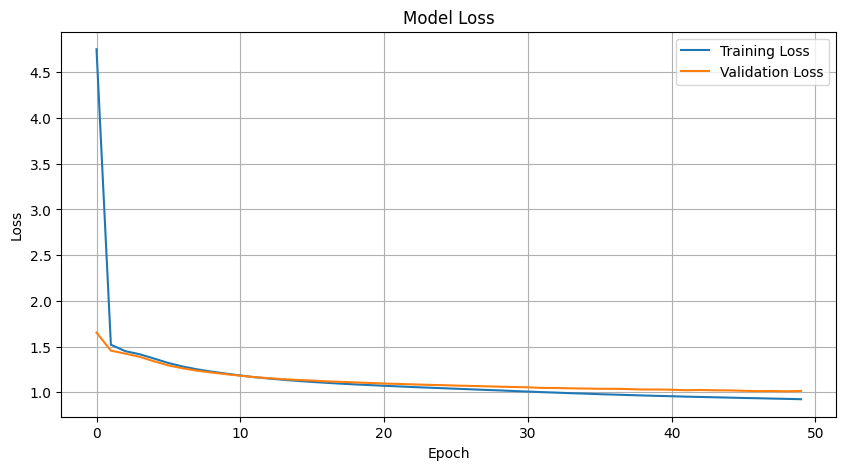

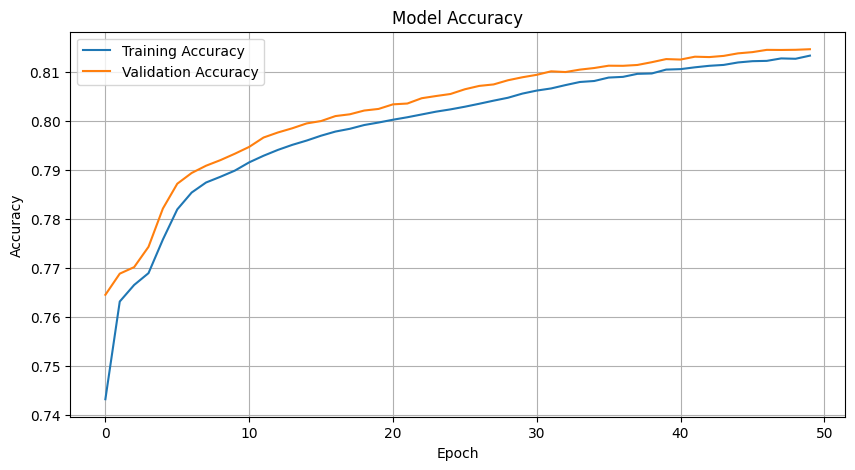

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
image_features = np.load("/kaggle/working/image_features.npy", allow_pickle=True).item()

In [24]:
from nltk.translate.bleu_score import sentence_bleu

In [25]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(model, image_features_dict, captions_dict, tokenizer, max_length):
    """Evaluate BLEU score using corpus-level calculation."""
    references = []
    hypotheses = []
    for image_id, features in image_features_dict.items():
        if image_id not in captions_dict:
            continue
        true_captions = [caption.split() for caption in captions_dict[image_id]]
        reshaped_features = np.array(features).reshape(1, -1)
        predicted_caption = predict_caption(model, reshaped_features, tokenizer, max_length).split()
        references.append(true_captions)
        hypotheses.append(predicted_caption)

    # Calculate BLEU score at corpus level
    return corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0.5, 0.5))

In [26]:
def predict_caption(model, image_features, tokenizer, max_length):
    """Generate caption for a given image using the trained model."""
    input_seq = tokenizer.texts_to_sequences(['<start>'])[0]
    input_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')

    result_caption = []
    for _ in range(max_length):
        predictions = model.predict([image_features, input_seq], verbose=0)
        predicted_id = np.argmax(predictions[0, len(result_caption)])
        word = tokenizer.index_word.get(predicted_id, "<unk>")

        # Stop if <end> token is generated
        if word == '<end>':
            break

         # Stop if <unk> is generated and there's no meaningful output
        if word == "<unk>" and len(result_caption) > 0:
            break

        # Add predicted word to the result caption
        result_caption.append(word)

        # Update the input sequence for the next prediction
        if len(result_caption) < max_length:  # Prevent out-of-bounds error
            input_seq[0, len(result_caption)] = predicted_id
        else:
            break

    # Return the caption, omitting the <start> token
    return ' '.join(result_caption)


Predicted: dogs in a field of a field .
Actual: ['a dog in a snowy area .', 'a spotted dog catching a ball on a snowy field .', 'a white and brown spotted dog runs along the snow to catch a ball .', 'a white dog is running fast on a trail covered by snow .', 'the brown and white dog is playing in the snow .']


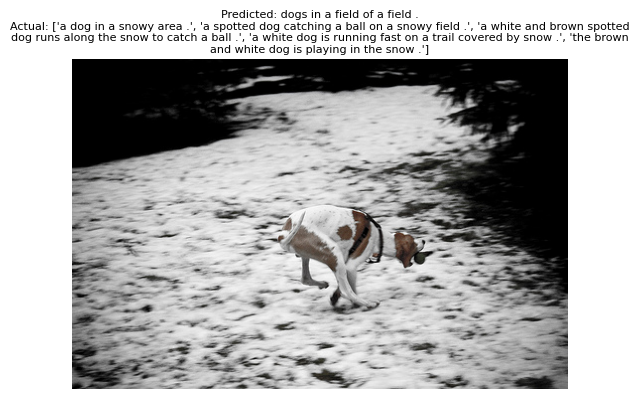

Predicted: dogs in a field .
Actual: ['a black and white dog is playing with a ball on a lawn .', 'a black and white dog jumps up as a ball is thrown over his head .', 'dog jumping looking up and small white ball in air passed by', 'the black and white dog is attempting to catch a ball in the garden .', 'the dog jumps up waiting to catch something being thrown .']


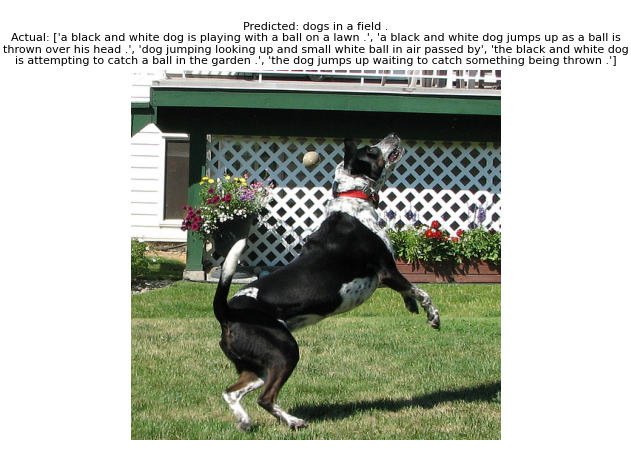

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display image with predicted and actual captions
def display_image_with_captions(image_path, predicted_caption, actual_captions):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_caption}\nActual: {actual_captions}", fontsize=8, wrap=True)
    plt.show()

# Display images with captions
for image_id in list(image_features.keys())[:2]:
    features = np.array(image_features[image_id]).reshape(1, -1)
    caption = predict_caption(caption_model, features, tokenizer, max_length)
    actual = captions_dict[image_id]
    print(f"Predicted: {caption}")
    print(f"Actual: {actual}")

    # Path to the image file
    image_file = f"{images_dir}/{image_id}.jpg"  # Update the extension if needed
    display_image_with_captions(image_file, caption, actual)

In [28]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# # Function to display image with predicted and actual captions
# def display_image_with_captions(image_path, predicted_caption, actual_captions):
#     img = mpimg.imread(image_path)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f"Predicted: {predicted_caption}\nActual: {actual_captions}", fontsize=8, wrap=True)
#     plt.show()

# # Display images with captions
# for image_id in list(image_features.keys())[:2]:
#     features = np.array(image_features[image_id]).reshape(1, -1)
#     caption = predict_caption(caption_model, features, tokenizer, max_length)
#     actual = captions_dict[image_id]
#     print(f"Predicted: {caption}")
#     print(f"Actual: {actual}")

#     # Path to the image file
#     image_file = f"{images_dir}/{image_id}.jpg"  # Update the extension if needed
#     display_image_with_captions(image_file, caption, actual)


In [29]:
# Evaluate BLEU score on validation data
print("Evaluating BLEU Score...")
bleu_score = evaluate_bleu(caption_model, image_features, captions_dict, tokenizer, max_length)
print(f"BLEU Score: {bleu_score}")

Evaluating BLEU Score...
BLEU Score: 0.0014538606121404585
